In [1]:
import pandas as pd
import numpy as np

In [2]:
fpath = 'tst_data/'

df = pd.DataFrame(pd.read_pickle(fpath+'20240127.pkl'))

In [3]:
raw_data_list = []

period = pd.date_range('20240101', '20240328')

for ts in period:
    date = str(ts.year) + str(ts.month).zfill(2) + str(ts.day).zfill(2)

    raw_data_list.append(pd.DataFrame(pd.read_pickle(fpath + date + '.pkl')))
    

In [4]:
df = pd.concat(raw_data_list).reset_index(drop=True)

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584210 entries, 0 to 1584209
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   titles  1584210 non-null  object
 1   dates   1584210 non-null  object
dtypes: object(2)
memory usage: 307.4 MB


히트맵 제작 과정

1. 데이터 불러오기 + 합치기
2. 전체 단어 목록 생성 -> 정제 + 토큰화 선행
3. (제목, 일자, 단어 bow) 형태의 데이터프레임으로 변형
4. (일자, 일자 내 단어 bow reduce) 형식으로 변환 -> 피봇 테이블
5. x->일자, y-> 단어 중 일정 조건에 맞는 단어만 선택
6. 히트맵으로 시각화 -> sns

In [6]:
import tst_module as func

In [7]:
raw_titles = df['titles'].copy()
raw_titles.sample(10)

403472                                  인사말하는 김영호 통일장관
502490     삼성SDI 작년 매출 22.7조 '사상 최대'…올해 고부가로 질적 성장(종합)
1200827            대진연, 국민의힘 당사 난입…"이토 히로부미 논란 성일종 사퇴"
1378015               "순간풍속 초속 20m 이상"…부산 강풍주의보, 낼 밤까지
587273                              [편집자 레터] 초중고생 필독서?
1151495                [건강플러스] 찰나의 사고, 기나긴 고통…상완신경총 손상
186197            “다리 근력 30% 증강” 고령자 맞춤형 ‘웨어러블 로봇’ 나왔다
26737               박상규 SK이노 사장 "체질개선 시급, 비효율·낭비 개선해야"
405908         단통법 폐지 추진하지만…갤S24 등 휴대폰 가격 인하까지는 '첩첩산중'
1419964                   부산대 의대 교수들 "25일부터 사직서 제출 시작"
Name: titles, dtype: object

In [8]:
raw_titles.sample(10).apply(func.normalize_punct)

1352175                        글로컬대 합종연횡 부산외대 경성대도 연합대 로 뭉친다
98327      충청출신 0.5선서 집권당 총선 공천관리 핵심으로 여의도 신데렐라 된 장동혁 의원 ...
333384                          이준석 당대표 개혁신당 출범 제3지대 빅텐트 가속화
851665                       새로 산 옷 안 빨고 그대로 입다간 피부에 이 증상 위험
600349                    의사 2만7000명 부족은 오류 공의모 보사연에 민사소송 제기
517480                               김종열 의용소방대원 심정지 환자 살려 화제
1364633                         尹 가짜뉴스 민주주의 위협 청년 국정 동반자 삼아야
157521                                 2024 LCK 스프링 개막 미디어데이
1351178                        가상자산 열풍에 K게임 블록체인 프로젝트 다시 기지개
781613                              홍성글로벌바베큐페스티벌 경제효과 488억 원
Name: titles, dtype: object

In [9]:
#raw_titles.apply(func.get_impurity_score).mean()

In [10]:
%%time

clean_titles = raw_titles.apply(func.normalize_punct)

CPU times: total: 38.2 s
Wall time: 39.1 s


In [11]:
#clean_titles.apply(func.get_impurity_score).mean()

In [12]:
df_clean = pd.concat([clean_titles, df['dates']], axis=1)
df_clean

,titles,dates
0,尹 3년차도 카르텔 타파 이젠 개혁과제 실행에 더 진력해야,20240101
1,일본서 한신 대지진보다 큰 규모 7.6 강진 피해 현황 집계 중,20240101
2,동해안에도 지진해일 여파 인명 물적 피해 없어,20240101
3,내일 오전까지 중부에 눈 비,20240101
4,성낙인 창녕군수 2024년 청룡처럼 비상하는 창녕 되도록 노력할 것,20240101
...,...,...
1584205,국회의원 35% 불경기에도 재산 늘었다 42명은 1억원 이상,20240328
1584206,한총리 83억1천만원 산업연구원장 152억 신고,20240328
1584207,안덕근 산업장관 48억원 신고 주식가치 상승으로 4천500만원,20240328
1584208,JP MB 서예작품 하프 고위 공직자 이색 재산 눈길,20240328


In [13]:
df_clean.isna().sum()

titles    0
dates     0
dtype: int64

In [14]:
from konlpy import tag

kr_module = tag.Okt()

In [15]:
df_clean['titles'].sample(10).apply(func.custom_tokenize, kr_module=kr_module)

222704             미국 13 번째 김치 날 제정 눈앞 뉴저지주 상원 통과
497192                                      맨발 휴식
595324          탄소 배출 량 유지 하면 여름철 서울 사망자 82% 늘어난다
373138                       이정식 장관 청년 장애인 등 간담 회
1037476                       녹색 정의당 비례 1 석 축소 규탄
1013837              레이디 가구 안전성 높인 멜로 데이 베드 침대 출시
778647            조국 검찰 독재 정권 심판 민주당 연합 국민 뜻 따를 것
355926             대형 마트 공휴일 의무 휴업 없앤다 단 통법 전면 폐지
441785         나주시 2023 나주 축제 평가 보고 회 개최 개선 방향 도출
743244     기름값 떨어지면 뭐 하나 서비스 물가 치솟는데 5월 금리인하 물 거품
Name: titles, dtype: object

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
%%time

ko_cntvec = CountVectorizer()

X = df_clean['titles'].sample(1000).apply(func.custom_tokenize, kr_module=kr_module)

ko_ct = ko_cntvec.fit_transform(X, )
ko_ct

CPU times: total: 5.61 s
Wall time: 2.33 s


<1000x4244 sparse matrix of type '<class 'numpy.int64'>'
	with 7338 stored elements in Compressed Sparse Row format>

1. 기간 입력
2. 해당 기간 내의 데이터 적재
3. 각 제목 별 단어 빈도 수 생성 -> (제목 인덱스, 날짜, 단어, 빈도) 식의 긴 형식으로
4. 피봇 테이블 생성

In [27]:
tokenized_titles = df_clean.iloc[ : 173499]
tokenized_titles

,titles,dates
0,尹 3년차도 카르텔 타파 이젠 개혁과제 실행에 더 진력해야,20240101
1,일본서 한신 대지진보다 큰 규모 7.6 강진 피해 현황 집계 중,20240101
2,동해안에도 지진해일 여파 인명 물적 피해 없어,20240101
3,내일 오전까지 중부에 눈 비,20240101
4,성낙인 창녕군수 2024년 청룡처럼 비상하는 창녕 되도록 노력할 것,20240101
...,...,...
173494,제1회 소집 아트페어 오는 13일 2부 개막,20240110
173495,2024 찾아가는 배우술 훈련,20240110
173496,2024 강원특별자치도 사회복지인 신년교례회,20240110
173497,눈길에 미끄러질까 긴장되는 출근 길,20240110


In [29]:
tokenized_titles['titles'] = tokenized_titles['titles'].apply(func.custom_tokenize, kr_module=kr_module)
tokenized_titles.sample(10)

C:\Users\davidbowman\AppData\Local\Temp\ipykernel_19488\3680185822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_titles['titles'] = tokenized_titles['titles'].apply(func.custom_tokenize, kr_module=kr_module)


,titles,dates
14832,일자리 창 출에 진심 한국 맥도날드 올해 첫 대규모 채용 나서,20240102
107991,멧돼지 잡으려다 60 대 전문 엽사 사망,20240108
86486,상반기 물가 2% 대 달성 설 성수 품 할인 등 과감 드라이브,20240105
46190,권익현 군수 세바퀴 경제 튼튼하고 흔들리지 않는 부안 건설,20240103
140200,USA TRANSPORT ACCIDENT,20240109
135140,어촌 어항 공단 하우 목동 항 전 흘 동 항 어촌 정주 여건 개선 공사 착공,20240109
97750,김정은 일본 지진 총리 각하 칭하 이례 적 위로,20240106
113752,멘탈 관리 거울 생체 신호 감지 헤드셋 AI 일상 녹아 들다,20240108
136418,경기도 미래 첨단 분야 인재 양성 110억 투입,20240109
83531,공정 거래 위원회,20240105


In [31]:
from collections import Counter

In [32]:
tst_df = tokenized_titles.iloc[0].copy()
tst_df

titles    尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야
dates                                20240101
Name: 0, dtype: object

1. (원본 + 카운터) 생성
2. ((인덱스 + 날짜) * 단어 목록) 식의 인덱스 생성 + 값은 빈도로
3. reset index
4. pivot table

In [48]:
Counter(tst_df['titles'].split(' '))

Counter({'尹': 1,
         '3년': 1,
         '차도': 1,
         '카르텔': 1,
         '타파': 1,
         '이': 1,
         '젠': 1,
         '개혁': 1,
         '과제': 1,
         '실행': 1,
         '더': 1,
         '진력': 1,
         '해야': 1})

In [44]:
tst_df2 = pd.DataFrame.from_dict(Counter(tst_df['titles'].split(' ')), orient='index').reset_index()
tst_df2

,index,0
0,尹,1
1,3년,1
2,차도,1
3,카르텔,1
4,타파,1
5,이,1
6,젠,1
7,개혁,1
8,과제,1
9,실행,1


In [49]:
tst_df2.index = [1]*len(tst_df2)
tst_df2

,index,0
1,尹,1
1,3년,1
1,차도,1
1,카르텔,1
1,타파,1
1,이,1
1,젠,1
1,개혁,1
1,과제,1
1,실행,1


In [53]:
tst_df2.index = [(0, tokenized_titles['dates'][0])]*len(tst_df2)
tst_df2

,index,0
"(0, 20240101)",尹,1
"(0, 20240101)",3년,1
"(0, 20240101)",차도,1
"(0, 20240101)",카르텔,1
"(0, 20240101)",타파,1
"(0, 20240101)",이,1
"(0, 20240101)",젠,1
"(0, 20240101)",개혁,1
"(0, 20240101)",과제,1
"(0, 20240101)",실행,1


In [55]:
tst_df2.index = [(0, tokenized_titles['dates'][0])]*len(tst_df2)
tst_df2

ValueError: Length mismatch: Expected axis has 13 elements, new values have 26 elements

In [57]:
pd.MultiIndex.from_tuples([(0, tokenized_titles['dates'][0])]*len(tst_df2))

MultiIndex([(0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101'),
            (0, '20240101')],
           )

In [58]:
tst_df2.index = pd.MultiIndex.from_tuples([(0, tokenized_titles['dates'][0])]*len(tst_df2))
tst_df2

index  0
0 20240101     尹  1
  20240101    3년  1
  20240101    차도  1
  20240101   카르텔  1
  20240101    타파  1
  20240101     이  1
  20240101     젠  1
  20240101    개혁  1
  20240101    과제  1
  20240101    실행  1
  20240101     더  1
  20240101    진력  1
  20240101    해야  1

In [59]:
tst_df2.reset_index()

,level_0,level_1,index,0
0,0,20240101,尹,1
1,0,20240101,3년,1
2,0,20240101,차도,1
3,0,20240101,카르텔,1
4,0,20240101,타파,1
5,0,20240101,이,1
6,0,20240101,젠,1
7,0,20240101,개혁,1
8,0,20240101,과제,1
9,0,20240101,실행,1


In [64]:
tst_df3 = tokenized_titles.iloc[0].copy()
tst_df3

titles    尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야
dates                                20240101
Name: 0, dtype: object

In [65]:
cntvec = Counter(tst_df3['titles'].split(' '))
cntvec

Counter({'尹': 1,
         '3년': 1,
         '차도': 1,
         '카르텔': 1,
         '타파': 1,
         '이': 1,
         '젠': 1,
         '개혁': 1,
         '과제': 1,
         '실행': 1,
         '더': 1,
         '진력': 1,
         '해야': 1})

In [96]:
tst_df4 = pd.concat([tst_df3, pd.Series(cntvec), pd.Series(0, index=['index'])])
tst_df4

titles    尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야
dates                                20240101
尹                                           1
3년                                          1
차도                                          1
카르텔                                         1
타파                                          1
이                                           1
젠                                           1
개혁                                          1
과제                                          1
실행                                          1
더                                           1
진력                                          1
해야                                          1
index                                       0
dtype: object

In [97]:
tst_df4 = pd.DataFrame(tst_df4).T
tst_df4

,titles,dates,尹,3년,차도,카르텔,타파,이,젠,개혁,과제,실행,더,진력,해야,index
0,尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야,20240101,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [98]:
tst_df4 = tst_df4.drop('titles', axis=1)

In [99]:
tst_df4

,dates,尹,3년,차도,카르텔,타파,이,젠,개혁,과제,실행,더,진력,해야,index
0,20240101,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [100]:
tst_df4 = tst_df4.melt(
    id_vars=['dates', 'index']
)
tst_df4

,dates,index,variable,value
0,20240101,0,尹,1
1,20240101,0,3년,1
2,20240101,0,차도,1
3,20240101,0,카르텔,1
4,20240101,0,타파,1
5,20240101,0,이,1
6,20240101,0,젠,1
7,20240101,0,개혁,1
8,20240101,0,과제,1
9,20240101,0,실행,1


In [103]:
tst_df4 = tst_df4.rename(columns={'variable': 'tokens', 'value': 'counts'})

In [104]:
tst_df4

,dates,index,tokens,counts
0,20240101,0,尹,1
1,20240101,0,3년,1
2,20240101,0,차도,1
3,20240101,0,카르텔,1
4,20240101,0,타파,1
5,20240101,0,이,1
6,20240101,0,젠,1
7,20240101,0,개혁,1
8,20240101,0,과제,1
9,20240101,0,실행,1


In [197]:
def melt_record(index, record):
    # if len(record['titles']) == 0 : print('zero size len')
    # print(index)
    melten = Counter(record['titles'].split(' '))
    melten = pd.DataFrame.from_dict(melten, orient='index').T
    melten['index'] = index
    melten['dates'] = record['dates']
    print(melten)
    melten = melten.melt(id_vars=['index', 'dates'])
    print(melten)
    melten = melten.rename(columns={'variable': 'tokens', 'value': 'counts'})

    return melten

In [198]:
melt_record(0, pd.Series({'titles': 'value chain', 'dates': '20230101'}))

   value  chain  index     dates
0      1      1      0  20230101


ValueError: value_name (value) cannot match an element in the DataFrame columns.

In [205]:
def melt_record(index, record):
    # if len(record['titles']) == 0 : print('zero size len')
    # print(index)
    melten = Counter(record['titles'].split(' '))
    melten = pd.DataFrame.from_dict(melten, orient='index').T
    melten['index'] = index
    melten['dates'] = record['dates']
    #print(melten)
    melten = melten.melt(id_vars=['index', 'dates'], var_name='tokens', value_name='counts')
    #|print(melten)
    melten = melten.rename(columns={'variable': 'tokens', 'value': 'counts'})

    return melten

In [200]:
melt_record(0, pd.Series({'titles': 'value chain', 'dates': '20230101'}))

   value  chain  index     dates
0      1      1      0  20230101
   index     dates tokens  counts
0      0  20230101  value       1
1      0  20230101  chain       1


,index,dates,tokens,counts
0,0,20230101,value,1
1,0,20230101,chain,1


In [201]:
melt_record(0, tokenized_titles.iloc[0])

   尹  3년  차도  카르텔  타파  이  젠  개혁  과제  실행  더  진력  해야  index     dates
0  1   1   1    1   1  1  1   1   1   1  1   1   1      0  20240101
    index     dates tokens  counts
0       0  20240101      尹       1
1       0  20240101     3년       1
2       0  20240101     차도       1
3       0  20240101    카르텔       1
4       0  20240101     타파       1
5       0  20240101      이       1
6       0  20240101      젠       1
7       0  20240101     개혁       1
8       0  20240101     과제       1
9       0  20240101     실행       1
10      0  20240101      더       1
11      0  20240101     진력       1
12      0  20240101     해야       1


,index,dates,tokens,counts
0,0,20240101,尹,1
1,0,20240101,3년,1
2,0,20240101,차도,1
3,0,20240101,카르텔,1
4,0,20240101,타파,1
5,0,20240101,이,1
6,0,20240101,젠,1
7,0,20240101,개혁,1
8,0,20240101,과제,1
9,0,20240101,실행,1


In [202]:
def melt_titles(titles):
    melten_records = []

    print(f'melt : {len(titles)} records')
    for i, record in titles.iterrows():
        melten_records.append(melt_record(i, record))
        if i % 10000 == 0 : print('\nnow on record', end='\t')
        if i % 1000 == 0 : print(i, end='\t')

    melten_records = pd.concat(melten_records)

    return melten_records

In [203]:
melt_titles(tokenized_titles.iloc[:10])

melt : 10 records
   尹  3년  차도  카르텔  타파  이  젠  개혁  과제  실행  더  진력  해야  index     dates
0  1   1   1    1   1  1  1   1   1   1  1   1   1      0  20240101
    index     dates tokens  counts
0       0  20240101      尹       1
1       0  20240101     3년       1
2       0  20240101     차도       1
3       0  20240101    카르텔       1
4       0  20240101     타파       1
5       0  20240101      이       1
6       0  20240101      젠       1
7       0  20240101     개혁       1
8       0  20240101     과제       1
9       0  20240101     실행       1
10      0  20240101      더       1
11      0  20240101     진력       1
12      0  20240101     해야       1

now on record	0	   일본  한신  대지진  큰  규모  7.6  강진  피해  현황  집계  중  index     dates
0   1   1    1  1   1    1   1   1   1   1  1      1  20240101
    index     dates tokens  counts
0       1  20240101     일본       1
1       1  20240101     한신       1
2       1  20240101    대지진       1
3       1  20240101      큰       1
4       1  20240101     규모       1
5  

,index,dates,tokens,counts
0,0,20240101,尹,1
1,0,20240101,3년,1
2,0,20240101,차도,1
3,0,20240101,카르텔,1
4,0,20240101,타파,1
...,...,...,...,...
6,9,20240101,명,1
7,9,20240101,다치고,1
8,9,20240101,인근,1
9,9,20240101,지역,1


In [206]:
melten_titles = melt_titles(tokenized_titles.iloc[21000 : 22000])
melten_titles

melt : 1000 records
21000	

,index,dates,tokens,counts
0,21000,20240102,이종호,1
1,21000,20240102,새해,1
2,21000,20240102,R,1
3,21000,20240102,D,1
4,21000,20240102,혁신,1
...,...,...,...,...
4,21999,20240102,새해,1
5,21999,20240102,일본,1
6,21999,20240102,몰카,1
7,21999,20240102,찍다,1


In [179]:
tokenized_titles.iloc[21900]

titles    Korea s potential G 5 inclusion could up natio...
dates                                              20240102
Name: 21900, dtype: object

In [185]:
melt_record(21900, tokenized_titles.iloc[21900])

   Korea  s  potential  G  5  inclusion  could  up  national  brand  value  \
0      1  1          1  1  1          1      1   1         1      1      1   

   index     dates  
0  21900  20240102  


ValueError: value_name (value) cannot match an element in the DataFrame columns.

In [160]:
tokenized_titles.iloc[22000]

titles    中 6 개국 비자 면제 한 달 간 11만 8000 명 무비 자 입국
dates                                  20240102
Name: 22000, dtype: object

In [161]:
tokenized_titles.iloc[21000]

titles    이종호 새해 R D 혁신 안 이행 AI 등 전략 기술 육성 힘쓰겠다
dates                                  20240102
Name: 21000, dtype: object

In [163]:
melt_record(22000, tokenized_titles.iloc[22000])

,index,dates,tokens,counts
0,22000,20240102,中,1
1,22000,20240102,6,1
2,22000,20240102,개국,1
3,22000,20240102,비자,1
4,22000,20240102,면제,1
5,22000,20240102,한,1
6,22000,20240102,달,1
7,22000,20240102,간,1
8,22000,20240102,11만,1
9,22000,20240102,8000,1


In [164]:
melt_record(21000, tokenized_titles.iloc[21000])

,index,dates,tokens,counts
0,21000,20240102,이종호,1
1,21000,20240102,새해,1
2,21000,20240102,R,1
3,21000,20240102,D,1
4,21000,20240102,혁신,1
5,21000,20240102,안,1
6,21000,20240102,이행,1
7,21000,20240102,AI,1
8,21000,20240102,등,1
9,21000,20240102,전략,1


In [207]:
melten_titles = melt_titles(tokenized_titles)
melten_titles

melt : 173499 records

now on record	0	1000	2000	3000	4000	5000	6000	7000	8000	9000	
now on record	10000	11000	12000	13000	14000	15000	16000	17000	18000	19000	
now on record	20000	21000	22000	23000	24000	25000	26000	27000	28000	29000	
now on record	30000	31000	32000	33000	34000	35000	36000	37000	38000	39000	
now on record	40000	41000	42000	43000	44000	45000	46000	47000	48000	49000	
now on record	50000	51000	52000	53000	54000	55000	56000	57000	58000	59000	
now on record	60000	61000	62000	63000	64000	65000	66000	67000	68000	69000	
now on record	70000	71000	72000	73000	74000	75000	76000	77000	78000	79000	
now on record	80000	81000	82000	83000	84000	85000	86000	87000	88000	89000	
now on record	90000	91000	92000	93000	94000	95000	96000	97000	98000	99000	
now on record	100000	101000	102000	103000	104000	105000	106000	107000	108000	109000	
now on record	110000	111000	112000	113000	114000	115000	116000	117000	118000	119000	
now on record	120000	121000	122000	123000	124000	125000	126000	127000	

,index,dates,tokens,counts
0,0,20240101,尹,1
1,0,20240101,3년,1
2,0,20240101,차도,1
3,0,20240101,카르텔,1
4,0,20240101,타파,1
...,...,...,...,...
2,173498,20240110,교육청,1
3,173498,20240110,고교,1
4,173498,20240110,입학,1
5,173498,20240110,추첨,1


In [243]:
melten_titles[melten_titles['tokens'] == '이']

,index,dates,tokens,counts
5,0,20240101,이,1
10,32,20240101,이,1
0,169,20240101,이,1
8,189,20240101,이,1
7,212,20240101,이,1
...,...,...,...,...
0,173188,20240110,이,1
5,173328,20240110,이,1
1,173331,20240110,이,1
0,173376,20240110,이,1


In [244]:
melten_titles[melten_titles['tokens'] == '젠']

,index,dates,tokens,counts
6,0,20240101,젠,1
6,768,20240101,젠,1
5,2106,20240101,젠,1
1,2131,20240101,젠,1
1,3087,20240101,젠,1
...,...,...,...,...
2,170664,20240110,젠,1
1,170932,20240110,젠,1
3,172138,20240110,젠,1
1,172240,20240110,젠,1


In [244]:
melten_titles[melten_titles['tokens'] == '젠']

,index,dates,tokens,counts
6,0,20240101,젠,1
6,768,20240101,젠,1
5,2106,20240101,젠,1
1,2131,20240101,젠,1
1,3087,20240101,젠,1
...,...,...,...,...
2,170664,20240110,젠,1
1,170932,20240110,젠,1
3,172138,20240110,젠,1
1,172240,20240110,젠,1


In [245]:
melten_titles[melten_titles['tokens'] == '이젠']

,index,dates,tokens,counts


In [210]:
hm_data = melten_titles.pivot_table(
    values='counts',
    index='dates',
    columns='tokens',
    aggfunc='sum',
    fill_value=0
)
hm_data

tokens,,$,$1,$1.5,$100,$160,$17.6,$175,$176,$2,...,ＴＷＩＣＥ,ＴＷＩＣＥ「ＹＥＳ,ＹＥＳ」,ａｅｓｐａがソ・テジの曲をリメーク,ｉＫＯＮバビー,ｍ,ｏｒ,ｔ,｜,･
dates,,,,,,,,,,,,,,,,,,,,,
20240101,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7,0,1,1,0
20240102,9,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,22,0,0,0,0
20240103,12,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,2,0,1,0,1
20240104,10,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,8,0,0,0,2
20240105,8,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2,0,1,0,0
20240106,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,0
20240107,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20240108,12,2,1,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
20240109,12,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2,0,1,0,0


In [214]:
hm_data.sum().sort_values(ascending=False).iloc[:100]

tokens
대      9069
이재명    7725
하는     7426
명      7342
새해     5568
       ... 
태      1585
광주     1582
내      1563
신년     1562
LG     1557
Length: 100, dtype: int64

In [215]:
hm_tokens = hm_data.sum().sort_values(ascending=False).iloc[:100].index
hm_tokens

Index(['대', '이재명', '하는', '명', '새해', '-', '들', '1', '전', '장', '2', '첫', '한동훈',
       '대표', '올해', '지원', '것', '이', '회', '사업', '대통령', '중', '등', '3', '한', 'AI',
       '2024', '해', '제', '적', '원', '2024년', '위', '영', '한국', '美', '국민', '부산',
       '공개', '피습', '장관', '서울', '건설', '회장', '기', '자', '개', '최대', '지역', 'CES',
       '5', '경찰', '4', '민주당', '삼성', '주', '안', '日', '尹', '위원장', '화', '정부', '기업',
       '시장', '할', '수', '일', '병원', '더', '성', '세', '총선', '전자', '비', '눈', '연',
       '당', '경제', '의원', '확대', '범', '추진', '인사', '선정', '형', '안전', '식', '힘', '투자',
       '시', '금융', '서', '해야', '기술', '아파트', '태', '광주', '내', '신년', 'LG'],
      dtype='object', name='tokens')

In [246]:
ord('-')

45

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔글꼴 경로 설정
font_path = 'C:/Windows/Fonts/gulim.ttc'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)

In [221]:
hm_data[hm_tokens].T

dates,20240101,20240102,20240103,20240104,20240105,20240106,20240107,20240108,20240109,20240110
tokens,,,,,,,,,,
대,561,1317,1228,1080,983,285,464,1155,978,1018
이재명,334,2035,1290,898,549,160,241,590,559,1069
하는,658,1132,990,854,702,200,167,784,1016,923
명,398,1197,848,898,627,293,372,969,816,924
새해,1862,1631,628,429,230,85,148,174,195,186
...,...,...,...,...,...,...,...,...,...,...
태,42,113,239,187,116,20,118,260,359,131
광주,106,168,243,416,129,9,60,143,169,139
내,123,186,158,222,120,37,95,176,197,249


In [231]:
hm_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 20240101 to 20240110
Columns: 57716 entries,  to ･
dtypes: int64(57716)
memory usage: 4.4 MB


In [233]:
hm_data.shape

(10, 57716)

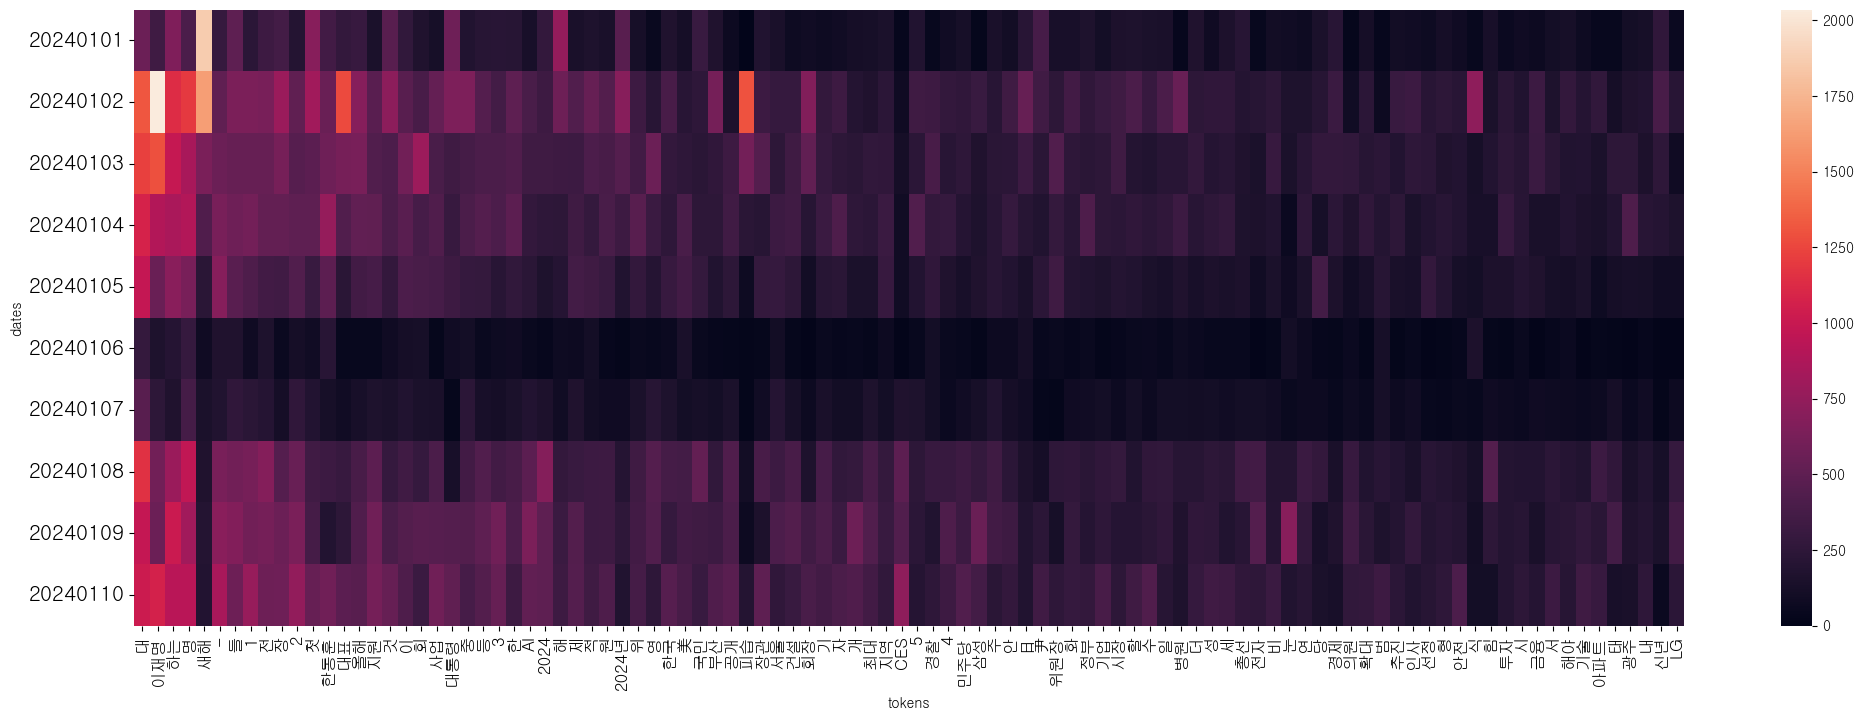

In [242]:
fig = plt.figure(figsize=(25, 8))

ax = sns.heatmap(
    hm_data[hm_tokens]
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

plt.savefig('tst_hm.png')

plt.show()

In [105]:
tokenized_titles.iloc[0]

titles    尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야
dates                                20240101
Name: 0, dtype: object

In [106]:
tokenized_titles.iloc[0]['titles']

'尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야'

In [108]:
pd.DataFrame(tokenized_titles.iloc[0]).T

,titles,dates
0,尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야,20240101


In [111]:
pd.DataFrame.from_dict(cntvec, orient='index').T

,尹,3년,차도,카르텔,타파,이,젠,개혁,과제,실행,더,진력,해야
0,1,1,1,1,1,1,1,1,1,1,1,1,1


In [105]:
tokenized_titles.iloc[0]

titles    尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야
dates                                20240101
Name: 0, dtype: object

In [122]:
cnt = 0

for i, record in tokenized_titles.iterrows():
    print(record)
    print(record.__class__)
    print(i)
    if cnt == 0 : break

titles    尹 3년 차도 카르텔 타파 이 젠 개혁 과제 실행 더 진력 해야
dates                                20240101
Name: 0, dtype: object
<class 'pandas.core.series.Series'>
0
